In [14]:
import yfinance as yf
import pandas as pd

eqr = yf.Ticker("EQR")
df = eqr.history(period="max")
df = df[['Close']]

df.reset_index(inplace=True)
df.rename(columns={"Date": "ds", "Close": "y"}, inplace=True)
df['ds'] = pd.to_datetime(df['ds'])
df['ds'] = df['ds'].dt.tz_localize(None)
df['y'] = df['y'].astype('float32')


df.fillna(method='ffill', inplace=True)

df.head()

<ipython-input-14-5aca85a045ca>:15: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


,ds,y
0,1993-08-12,2.754306
1,1993-08-13,2.670114
2,1993-08-16,2.694167
3,1993-08-17,2.706196
4,1993-08-18,2.706196


In [17]:
df.shape

(7996, 2)

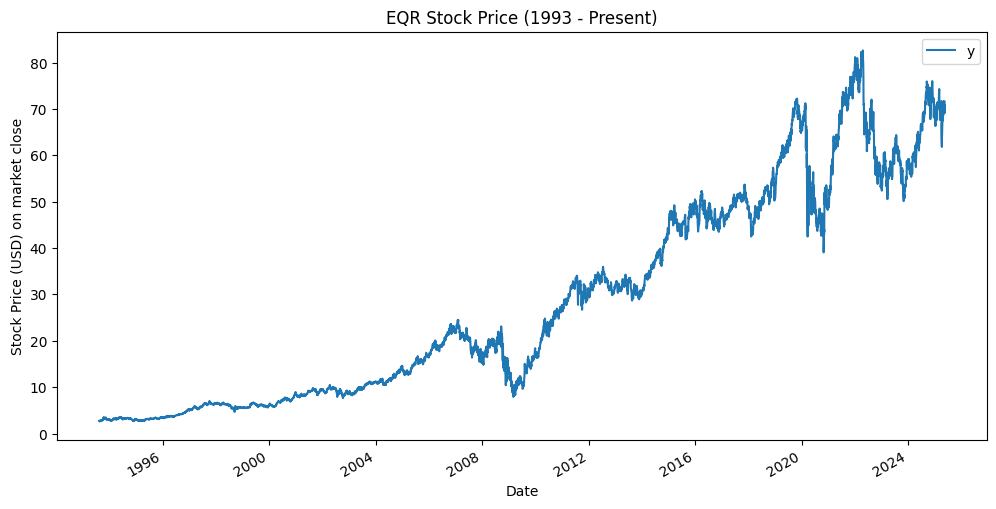

In [15]:
from matplotlib import pyplot as plt

df.plot(x='ds', y='y', title='EQR Stock Price (1993 - Present)', figsize=(12, 6))
plt.xlabel('Date')
plt.ylabel('Stock Price (USD) on market close')
plt.show()

In [16]:
from prophet import Prophet
m = Prophet()
m.fit(df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmplrcjbo4m/0mar7muv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplrcjbo4m/wky7oxtk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28326', 'data', 'file=/tmp/tmplrcjbo4m/0mar7muv.json', 'init=/tmp/tmplrcjbo4m/wky7oxtk.json', 'output', 'file=/tmp/tmplrcjbo4m/prophet_model4y2jpy74/prophet_model-20250518204211.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:42:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:42:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [18]:
future = m.make_future_dataframe(periods=365)
future.tail()

,ds
8356,2026-05-12
8357,2026-05-13
8358,2026-05-14
8359,2026-05-15
8360,2026-05-16


In [19]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
8356,2026-05-12,68.414532,62.961097,73.569653
8357,2026-05-13,68.376483,62.866299,74.494087
8358,2026-05-14,68.368270,62.622618,74.167657
8359,2026-05-15,68.391135,62.954942,74.300829
8360,2026-05-16,68.550965,62.699178,74.431412


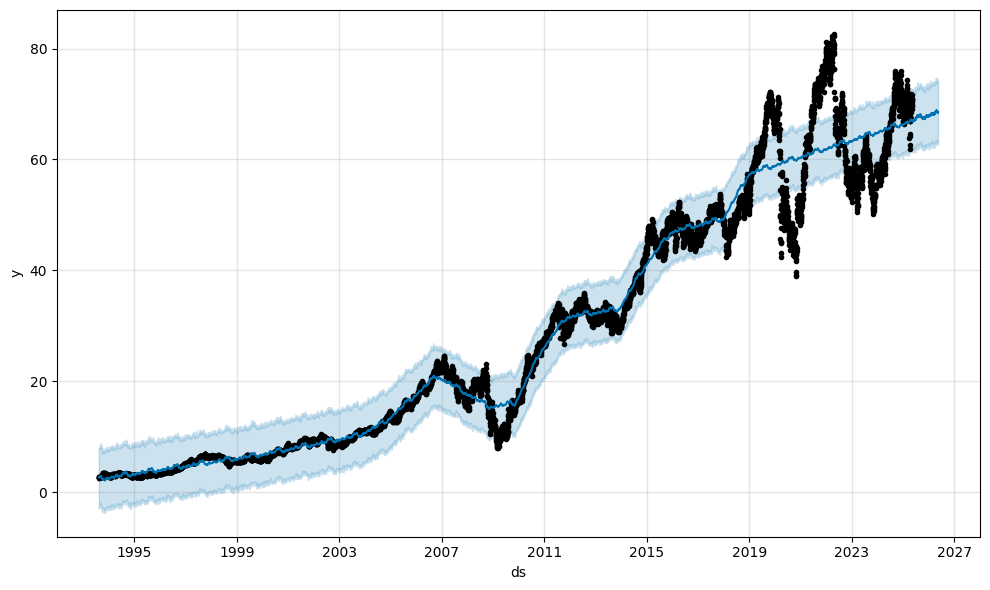

In [20]:
fig1 = m.plot(forecast)

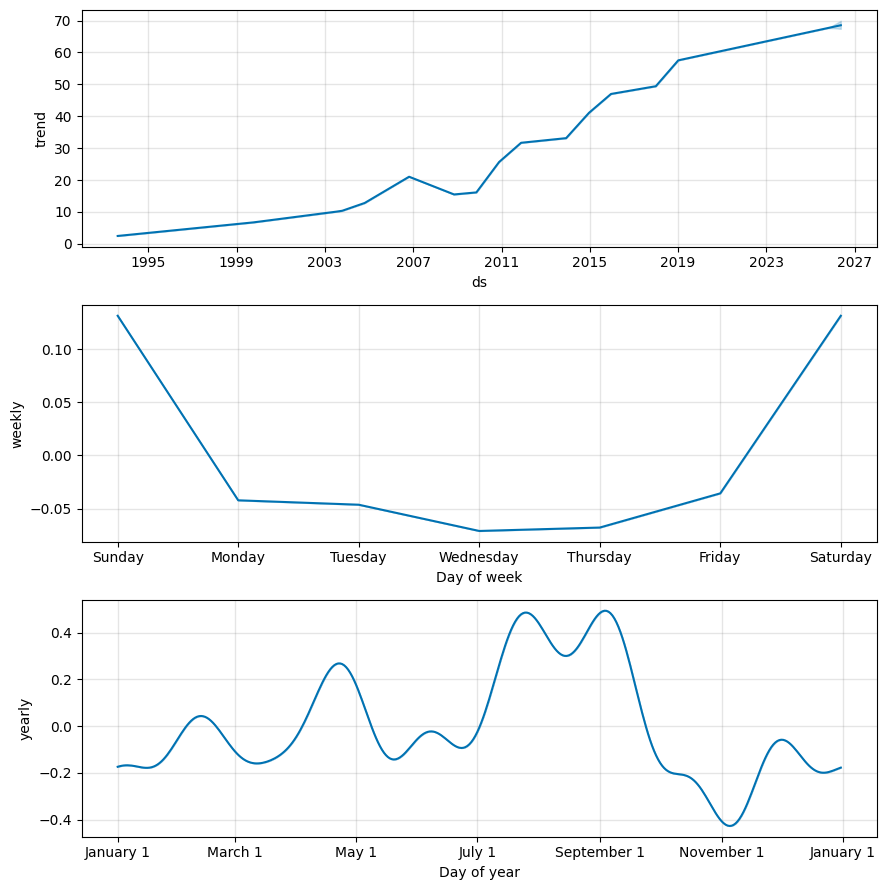

In [21]:
fig2 = m.plot_components(forecast)

In [22]:
train_end = round(len(df) * 0.7)

train = df.iloc[:train_end]
test = df.iloc[train_end:]

model = Prophet()
model.fit(train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmplrcjbo4m/5gcw2u_u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplrcjbo4m/unamt5vo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27118', 'data', 'file=/tmp/tmplrcjbo4m/5gcw2u_u.json', 'init=/tmp/tmplrcjbo4m/unamt5vo.json', 'output', 'file=/tmp/tmplrcjbo4m/prophet_modelea3y5fqo/prophet_model-20250518211329.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:13:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:13:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


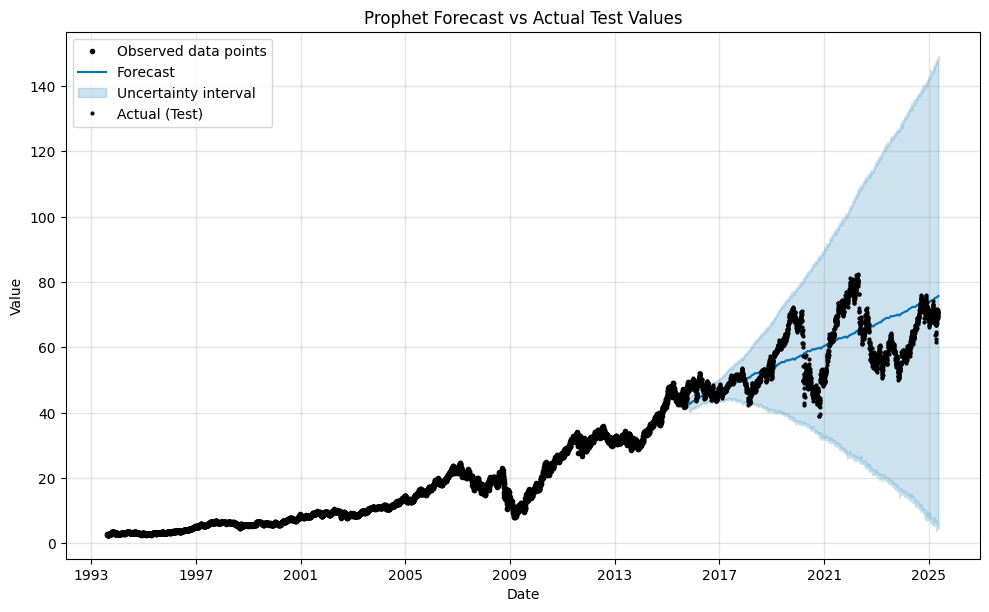

In [38]:
future = test[['ds']]
forecast = model.predict(future)

fig1 = model.plot(forecast)

plt.plot(test['ds'], test['y'], 'k.', label='Actual (Test)', markersize=4)

# Optional enhancements
plt.legend()
plt.title('Prophet Forecast vs Actual Test Values')
plt.xlabel('Date')
plt.ylabel('Value')
plt.grid(True)

plt.show()

In [24]:
results = test.copy()
results['yhat'] = forecast['yhat'].values

In [28]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(results['y'], results['yhat'])
rmse = np.sqrt(mean_squared_error(results['y'], results['yhat']))
mape = np.mean(np.abs((results['y'] - results['yhat']) / results['y'])) * 100

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

MAE: 6.50
RMSE: 8.16
MAPE: 11.16%


In [30]:
from prophet.diagnostics import cross_validation, performance_metrics

df_cv = cross_validation(model, initial='365 days', period='30 days', horizon='30 days')
df_p = performance_metrics(df_cv)
print(df_p[['mae', 'rmse', 'mape']])

INFO:prophet:Making 258 forecasts with cutoffs between 1994-08-21 00:00:00 and 2015-09-30 00:00:00


  0%|          | 0/258 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplrcjbo4m/5dj6l6lc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplrcjbo4m/yn_0127j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79378', 'data', 'file=/tmp/tmplrcjbo4m/5dj6l6lc.json', 'init=/tmp/tmplrcjbo4m/yn_0127j.json', 'output', 'file=/tmp/tmplrcjbo4m/prophet_model55xmokce/prophet_model-20250518211514.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:15:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:15:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplrcjbo4m/982jnww4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplrcjbo4m/rvgsy1xn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

         mae      rmse      mape
0   2.022912  3.247098  0.104148
1   2.036116  3.264151  0.104394
2   2.082224  3.339309  0.106573
3   2.101994  3.379799  0.107765
4   2.119225  3.399485  0.108603
5   2.125347  3.401400  0.109495
6   2.186347  3.462500  0.112124
7   2.197710  3.475416  0.113830
8   2.183062  3.462080  0.113583
9   2.178182  3.467358  0.113311
10  2.194755  3.499329  0.112620
11  2.218975  3.529005  0.115187
12  2.229489  3.559687  0.117207
13  2.259160  3.602455  0.121043
14  2.303141  3.643663  0.122369
15  2.320825  3.649521  0.122716
16  2.320773  3.648112  0.121051
17  2.320880  3.663903  0.120784
18  2.284163  3.615117  0.119320
19  2.251981  3.577675  0.119240
20  2.253486  3.580557  0.120687
21  2.313302  3.670337  0.124928
22  2.342886  3.704472  0.125439
23  2.339676  3.698943  0.124653
24  2.314674  3.661247  0.123688
25  2.293064  3.631816  0.124335
26  2.299547  3.637560  0.124658
27  2.293652  3.625203  0.124284


In [ ]:
#          mae      rmse      mape
# 0   2.022912  3.247098  0.104148
# 1   2.036116  3.264151  0.104394
# 2   2.082224  3.339309  0.106573
# 3   2.101994  3.379799  0.107765
# 4   2.119225  3.399485  0.108603
# 5   2.125347  3.401400  0.109495
# 6   2.186347  3.462500  0.112124
# 7   2.197710  3.475416  0.113830
# 8   2.183062  3.462080  0.113583
# 9   2.178182  3.467358  0.113311
# 10  2.194755  3.499329  0.112620
# 11  2.218975  3.529005  0.115187
# 12  2.229489  3.559687  0.117207
# 13  2.259160  3.602455  0.121043
# 14  2.303141  3.643663  0.122369
# 15  2.320825  3.649521  0.122716
# 16  2.320773  3.648112  0.121051
# 17  2.320880  3.663903  0.120784
# 18  2.284163  3.615117  0.119320
# 19  2.251981  3.577675  0.119240
# 20  2.253486  3.580557  0.120687
# 21  2.313302  3.670337  0.124928
# 22  2.342886  3.704472  0.125439
# 23  2.339676  3.698943  0.124653
# 24  2.314674  3.661247  0.123688
# 25  2.293064  3.631816  0.124335
# 26  2.299547  3.637560  0.124658
# 27  2.293652  3.625203  0.124284

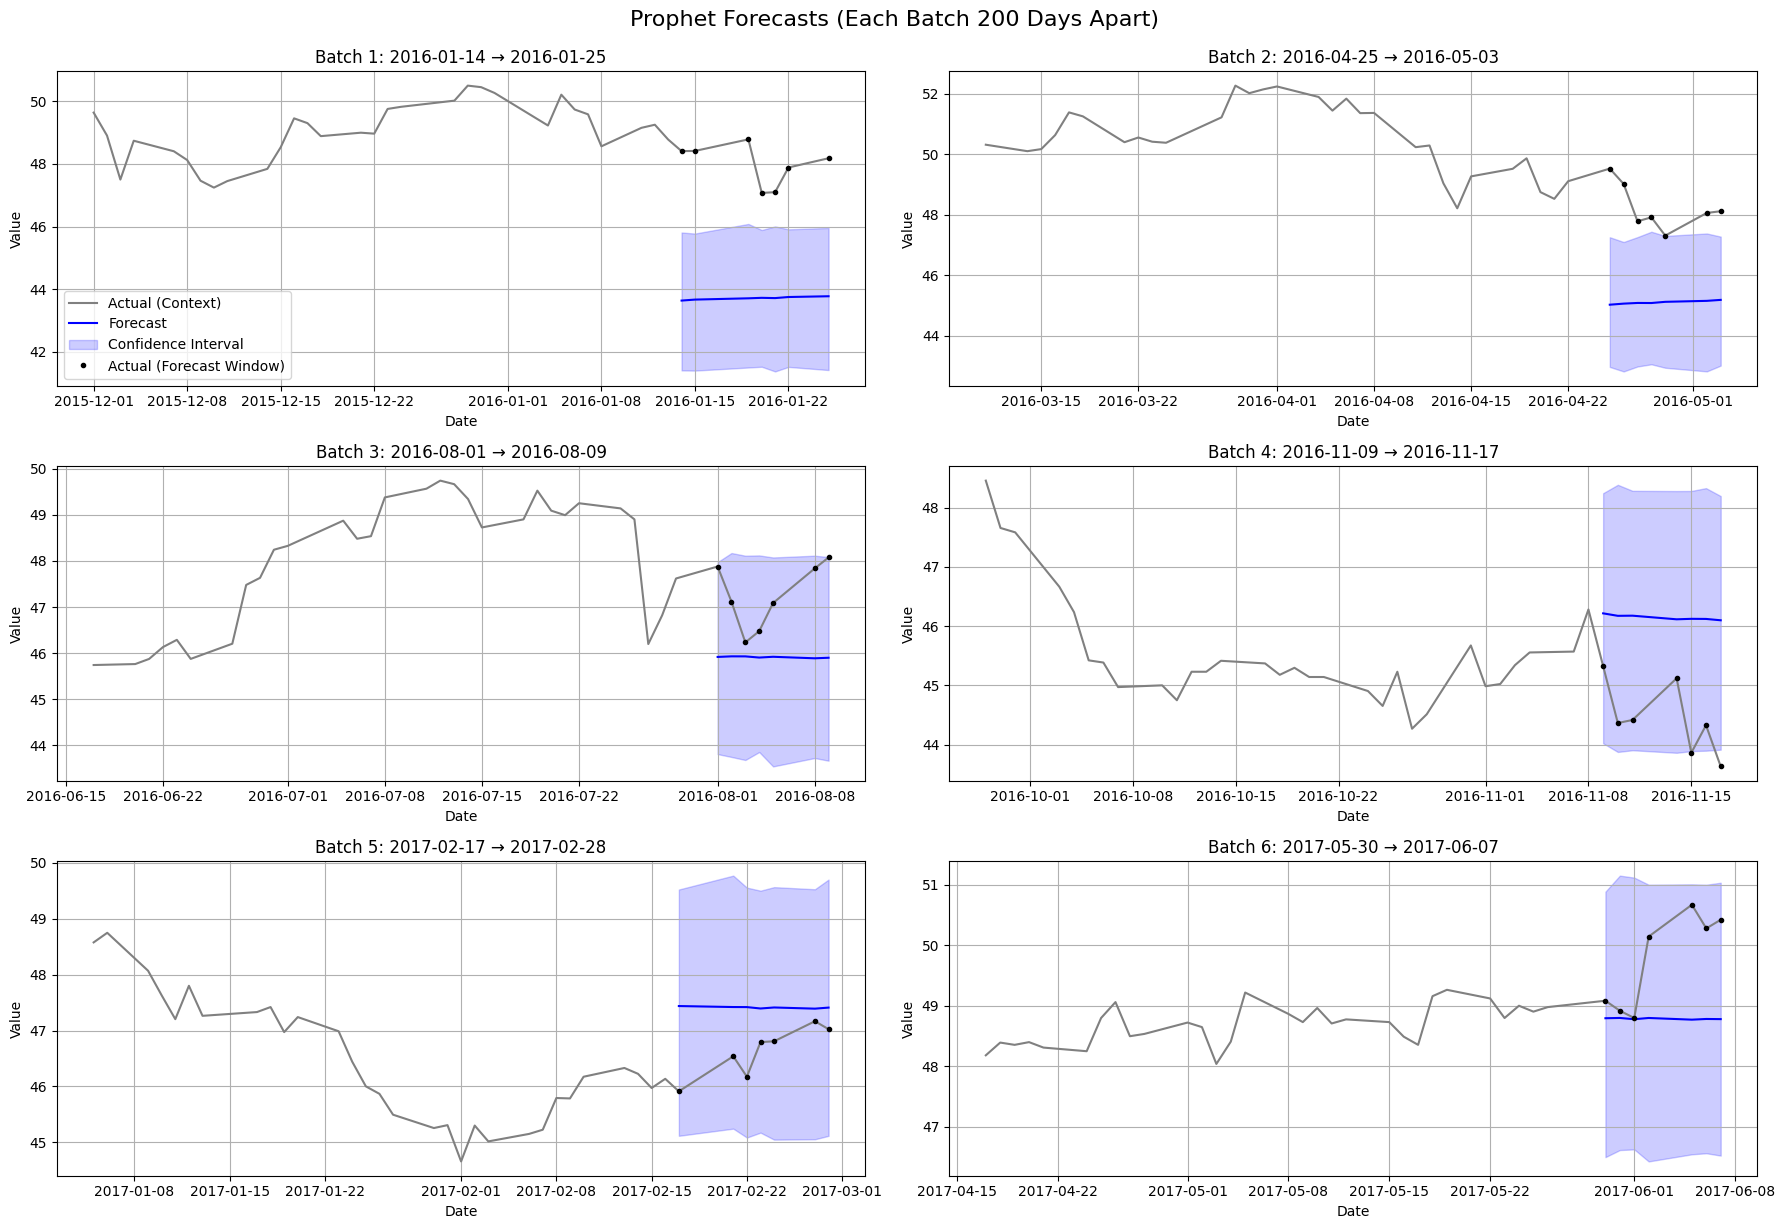

Average MAE: 2.036
Average RMSE: 6.142
Average MAPE: 4.279%


In [64]:
import matplotlib.pyplot as plt

context_days_before = 30
context_days_after = 7

test_dates_sorted = test['ds'].sort_values().reset_index(drop=True)

fig, axes = plt.subplots(3, 2, figsize=(18, 12), sharex=False)
axes = axes.flatten()

start_dates = [test['ds'].iloc[50] + pd.Timedelta(days=i * 100) for i in range(6)]

def get_closest_date(dates, target):
    idx = dates.searchsorted(target, side='left')
    if idx >= len(dates):
        return None
    return dates.iloc[idx]

valid_start_dates = []
for d in start_dates:
    closest = get_closest_date(test_dates_sorted, d)
    if closest is not None:
        valid_start_dates.append(closest)

mae_list = []
rmse_list = []
mape_list = []

for i, start_date in enumerate(valid_start_dates):
    start_idx = test.index[test['ds'] == start_date][0]
    plot_start_idx = max(0, start_idx - context_days_before)
    plot_end_idx = min(len(test), start_idx + context_days_after)

    if plot_end_idx > len(test):
        continue

    plot_batch = test.iloc[plot_start_idx:plot_end_idx]

    predict_end_idx = start_idx + 7
    test_batch = test.iloc[start_idx:predict_end_idx]
    future = test_batch[['ds']]

    forecast = model.predict(future)

    results = test_batch.copy()
    results['yhat'] = forecast['yhat'].values
    results['yhat_lower'] = forecast['yhat_lower'].values
    results['yhat_upper'] = forecast['yhat_upper'].values

    mae = mean_absolute_error(results['y'], results['yhat'])
    rmse = mean_squared_error(results['y'], results['yhat'])
    mape = np.mean(np.abs((results['y'] - results['yhat']) / results['y'])) * 100

    mae_list.append(mae)
    rmse_list.append(rmse)
    mape_list.append(mape)

    ax = axes[i]
    ax.plot(plot_batch['ds'], plot_batch['y'], label='Actual (Context)', color='gray')

    ax.plot(forecast['ds'], forecast['yhat'], label='Forecast', color='blue')
    ax.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'],
                    color='blue', alpha=0.2, label='Confidence Interval')

    ax.plot(future['ds'], test.loc[future.index, 'y'], 'k.', label='Actual (Forecast Window)')

    ax.set_title(f'Batch {i+1}: {future["ds"].iloc[0].date()} → {future["ds"].iloc[-1].date()}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Value')
    ax.grid(True)

axes[0].legend()
plt.tight_layout()
plt.suptitle('Prophet Forecasts (Each Batch 200 Days Apart)', fontsize=16, y=1.02)
plt.show()

print(f'Average MAE: {np.mean(mae_list):.3f}')
print(f'Average RMSE: {np.mean(rmse_list):.3f}')
print(f'Average MAPE: {np.mean(mape_list):.3f}%')
